# Load libraries, define folders

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
scripts = 'Scripts'
import seaborn as sns
import glob

sys.path.append(scripts)
import fastQHandling
import BLASTanalysis
import DeletionAnalysis
import scipy
import numpy as np
import math

from scipy import stats
from statsmodels.stats import multitest
from IPython.display import IFrame    
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#Superdirectory containing fastq files for all experiments
sequenceDirectory = "Sequencing"
#links to precompiled STAR indices
genomes = {'mRNA':'Database/human_WSN_star', 'vRNA':'Database/WSN_star'}
#fasta file for influenza genome
WSNfasta = 'Database/WSN_vRNA.fa'
#precompiled blast database for WSN_vRNA
WSNblastdb = 'Database/WSN_BLAST/WSN_vRNA'
#list of pcr adapters for trimming
adapterFile = 'Database/adapter.fa'

#Results
resultsDir = 'Results'
if not os.path.isdir(resultsDir):
    os.mkdir(resultsDir)
#blast variables for identifying junctions
percentIdentity = 90
wordSize = 10
gapOpen = 5
gapExtend = 2
eValue = 0.000001
outFormat = '"6 qseqid qlen qstart qend sstart send evalue sseqid qseq"'


#multiprocessing for mapping to speed things up a bit
from multiprocessing import Pool
numProcessors = 4
import subprocess
#some parameters for plotting

figureDirectory = 'Figures/'
if not os.path.isdir(figureDirectory):
    os.mkdir(figureDirectory)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 16, 'axes.titlesize':'medium',})
sns.set_style("white")
sns.set_style("ticks")
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
segments = ['PB1_vRNA','HA_vRNA','PB2_vRNA',  'PA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
fluColors = {}
for color, segment in enumerate(segments):
    fluColors[segment] = colors[color]
segments = ['PB2_vRNA', 'PB1_vRNA', 'PA_vRNA','HA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']



# FastQ reads, trimming, preparation for mapping

Collate all sequencing files

In [2]:

experiments = []
for directory in glob.glob(sequenceDirectory + '/*'):
    for file in glob.glob(directory + '/*.fastq*'):
        fileName = file.split('/')[-1]
        descriptors = fileName.split('_')
        biologicalReplicate = descriptors[0].split('-')[1]
        technicalReplicate = descriptors[0].split('-')[2]
        interferonState = descriptors[1]
        molecule = descriptors[2]
        read = descriptors[-2]
        #for this paper, currently only 1 run per experiment, but might as well add some flexibility.
        sequencingRun = '_'.join(descriptors[3:5])
        experiments += [pd.DataFrame({'experiment':[directory.split('/')[-1]], 'biological_replicate':[biologicalReplicate],
                                     'technical_replicate':[technicalReplicate], 'experimental_condition':[interferonState],
                                     'molecule_sequenced':[molecule], 'read_pair':[read], 'directory':[directory], 
                                      'file_name':[file], 'sequencing_run':[sequencingRun]})]
experiments = pd.concat(experiments).reset_index().drop(columns=['index'])
unique = experiments.groupby(['experiment', 'biological_replicate', 'technical_replicate', 'experimental_condition','molecule_sequenced']).file_name.apply(list).reset_index()
experiments.set_index(['experiment','biological_replicate','technical_replicate', 'experimental_condition','molecule_sequenced']).sort_values(by=['experiment', 'biological_replicate','technical_replicate','experimental_condition','molecule_sequenced'])   


read_pair  \
experiment   biological_replicate technical_replicate experimental_condition molecule_sequenced             
beta_sorting 1                    1                   depleted               mRNA                      R2   
                                                                             mRNA                      R1   
                                                                             vRNA                      R2   
                                                                             vRNA                      R1   
                                                      enriched               mRNA                      R1   
                                                                             mRNA                      R2   
                                                                             vRNA                      R2   
                                                                             vRNA                      R1   
                                  2                   depleted               mRNA                      R2   
                                                                             mRNA                      R1   
                                                                             vRNA                      R2   
                                                                             vRNA                      R1   
                                                      enriched               mRNA                      R2   
                                                                             mRNA                      R1   
                                                                             vRNA                      R2   
                                                                             vRNA                      R1   
             2                    1                   depleted               mRNA                      R2   
                                                                             mRNA                      R1   
                                                                             vRNA                      R2   
                                                                             vRNA                      R1   
                                                      enriched               mRNA                      R2   
                                                                             mRNA                      R1   
                                                                             vRNA                      R2   
                                                                             vRNA                      R1   
                                  2                   depleted               mRNA                      R2   
                                                                             mRNA                      R1   
                                                                             vRNA                      R2   
                                                                             vRNA                      R1   
                                                      enriched               mRNA                      R2   
                                                                             mRNA                      R1   
                                                                             vRNA                      R1   
                                                                             vRNA                      R2   

                                                                                                               directory  \
experiment   biological_replicate technical_replicate experimental_condition molecule_sequenced                            
beta_sorting 1                    1                   depleted               mRNA                Sequencing/beta_sorting   
                 

Simply summary statistics of fastQ files to ensure integrity of data. Using fastQC here and elsewhere, a java program developed by Babraham Bioinformatics, available here (http://www.bioinformatics.babraham.ac.uk/projects/fastqc/). Total reports are generated and saved in this repository, but only really want to look at length distribution, score/position distribution, and, lastly, the score distribution of reads.

In [3]:
def fastQC(tupleArgument):
    sampleName = tupleArgument[0]
    reads = tupleArgument[1]
    return {sampleName:fastQHandling.fastQCreport(sampleName=sampleName, reads=reads)}
figsDisplay = []
for experiment in set(experiments.experiment):
    for molecule in set(experiments[(experiments.experiment == experiment)].molecule_sequenced):
        reports = []
        results = {}
        samples = {}
        for index, row in experiments[(experiments.experiment == experiment) & (
                experiments.molecule_sequenced == molecule)].iterrows():
            sample = ''.join(['Virus #',str(row.biological_replicate),' replicate #', str(row.technical_replicate),
                              ' ', row.experimental_condition])
            read = row.file_name
            readName = row.sequencing_run + '_' + row.read_pair
            if sample not in samples.keys():
                samples[sample] = {readName:read}
            else:
                samples[sample][readName] = read
        popList = [(sample, samples[sample]) for sample in list(samples.keys())]
        while len(popList) > 0:
            with Pool(processes = numProcessors) as p:
                reports += p.map(fastQC, [popList.pop() for i in range(numProcessors) if len(popList) != 0])
        reports = {key:value for dictionary in reports for key, value in dictionary.items()} 
        a = fastQHandling.graphAllTheThings(data=reports, title=experiment + '_' + molecule)
        #pdf for publication
        plt.savefig(sequenceDirectory + '/' +  experiment + '/sequenceQC_' +molecule + '.pdf', format='pdf', bbox_inches = "tight")
        #png for showing here
        plt.savefig(sequenceDirectory + '/' +  experiment + '/sequenceQC_' +molecule + '.png', format='png', bbox_inches = "tight")
        plt.close()
        figsDisplay += [sequenceDirectory + '/' +  experiment + '/sequenceQC_' +molecule + '.png']
width = 128 * len(figsDisplay)
g = plt.figure(1, (width, 128))
spec = g.add_gridspec(ncols= len(figsDisplay),nrows=1)
for column, fig in enumerate(figsDisplay):
    ax = g.add_subplot(spec[0,column])
    img=mpimg.imread(fig)
    ax.imshow(img)
    ax.axis('off')


Remove adapters as this will impact mapping efficiency using the java program trimmomatic. Nothing concerning jumps out, so can continue. 

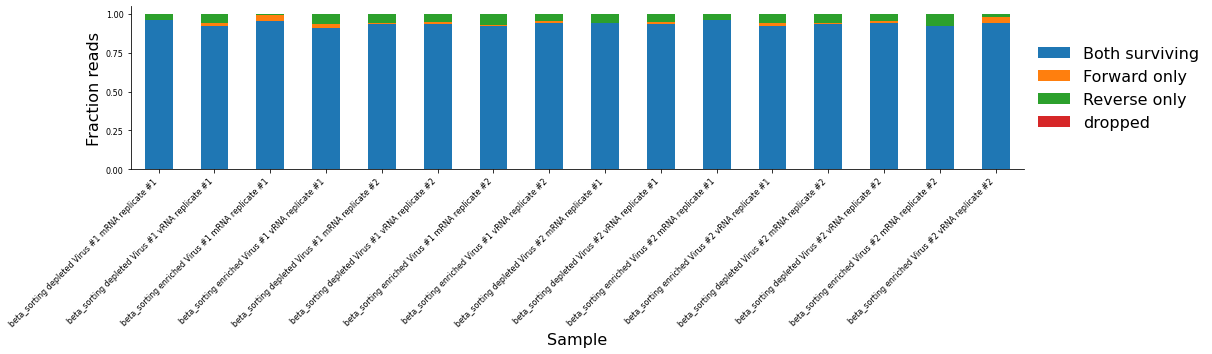

In [5]:
#list comprehension to get reports on trimming statistics. Using baseline recommendations of program creators.
#Can overwrite if need be. Does not rerun if already run in past, only grabs statistics. Pass rerun=True, if overwrite
#is desired.
for experiment in set(experiments.experiment):
    if not os.path.isdir('/'.join([sequenceDirectory, experiment, 'trimmed_reads'])):
        os.mkdir('/'.join([sequenceDirectory, experiment, 'trimmed_reads']))
rows = experiments.groupby(['experiment', 'biological_replicate', 'technical_replicate', 'experimental_condition','molecule_sequenced','sequencing_run']).file_name.apply(list).reset_index().iterrows()
stats = pd.concat([fastQHandling.trimCommandPaired(read1=row[1].file_name[0], 
                           read2= row[1].file_name[1],
                           outDirectory='/'.join([sequenceDirectory, row[1].experiment, 'trimmed_reads']),
                            adapterFile= adapterFile,
                            sampleName = ''.join([row[1].experiment + ' ' + row[1].experimental_condition + ' Virus #',str(row[1].biological_replicate) + ' ' + (str(row[1].molecule_sequenced)),' replicate #', str(row[1].technical_replicate)]),
                          threads = numProcessors) for row in rows]).set_index('Sample')
#return raw numbers from above as they are generally more useful, but go ahead and collapse to percentages here
stats=stats.div(stats['Input read pairs'], axis=0).drop(columns=['Input read pairs'])
ax = stats.loc[:,['Both surviving', 'Forward only', 'Reverse only', 'dropped']].plot.bar(stacked=True,figsize=(16,3), fontsize=8)
sns.despine()
ax.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xticks(rotation=45,horizontalalignment="right")
plt.ylabel('Fraction reads', fontsize=16)
plt.savefig(sequenceDirectory + '/trimming_statistics.pdf', format='pdf', bbox_inches = "tight")

# Alignment of reads

Next, mapping reads.

For this we will begin with STAR mapping to pregenerated genomes. Please see the manual for information on generating STAR indices if you do not know how. FASTA files for WSN will be uploaded, please locate your own human genome as it is too large to share via github.

Do not clip, set excessive penalties for junctions to prevent their inclusion.

Map read1 and read2 seperately for vRNA. NON-STANDARD. But would rather map all reads as independent entities and then fix flags and size distributions in a function-acknowledged fashion rather than using a set of mapper scoring that may not be appropriate for these populations of molecules.


In [6]:
for index, row in experiments.groupby(['experiment', 'biological_replicate', 'technical_replicate', 'experimental_condition','molecule_sequenced']).file_name.apply(list).reset_index().iterrows():
    #making sure pipeline supports multiple sequencing runs.
    experiment = row.experiment
    molecule = row.molecule_sequenced
    condition = row.experimental_condition
    bio_replicate = row.biological_replicate
    tech_replicate = row.technical_replicate
    sequences = experiments[(experiments.experiment == experiment) & (experiments.molecule_sequenced == molecule) & (
                            experiments.biological_replicate == bio_replicate) & (experiments.technical_replicate == tech_replicate) & (
                            experiments.experimental_condition == condition)]
    outDirectory = resultsDir + '/' +  experiment + '_STARalign'
    if not os.path.isdir(outDirectory):
        os.mkdir(outDirectory)
    #collate all R1s and associated R2s. ORDER CRITICAL, hence the whole song and dance here
    R1 = []
    R2 = []
    for index, row in sequences[sequences.read_pair == 'R1'].iterrows():
        read1 = row.file_name
        read2 = sequences[(sequences.sequencing_run == row.sequencing_run) & (
                sequences.read_pair == 'R2')].file_name.iloc[0]
        R1 += ['/'.join(read1.split('/')[:-1]) + '/trimmed_reads/' +read1.split('/')[-1]]
        R2 += ['/'.join(read2.split('/')[:-1]) + '/trimmed_reads/' +read2.split('/')[-1]]
    outprefix = outDirectory + '/' + 'Virus-' + str(bio_replicate) + '-' + str(tech_replicate) + '_' + condition + '_' + molecule
    for read in R1 + R2:
        unzipped = read[:-3]
        !gunzip -c $read > $unzipped
    genome = genomes[molecule]
    read1unzip = ','.join([read[:-3] for read in R1])
    read2unzip = ','.join([read[:-3] for read in R2])
    if(molecule == 'vRNA'):
        outprefix1 = outprefix + '_R1_'
        outprefix2 = outprefix + '_R2_'
        logFile1 =  outprefix1 + 'terminal.txt'
        logFile2 =  outprefix2 + 'terminal.txt'
        capture1 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $genome --readFilesIn $read1unzip --outFileNamePrefix $outprefix1 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx
        capture2 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $genome --readFilesIn $read2unzip --outFileNamePrefix $outprefix2 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx

        with open(logFile1, 'w') as outfile1, open(logFile2, 'w') as outfile2:
            for line in capture1:
                outfile1.write(line + '\n')
            for line in capture2:
                outfile2.write(line + '\n')
    else:
        outprefix = outprefix + '_'
        logFile =  outprefix + 'terminal.txt'
        capture = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $genome --readFilesIn $read1unzip $read2unzip --outFileNamePrefix $outprefix --outSAMtype BAM Unsorted
        with open(logFile, 'w') as outfile:
            for line in capture:
                outfile.write(line + '\n')
        outprefix = outprefix + 'vRNAmap_'
        genome = genomes['vRNA']
        logFile =  outprefix + 'terminal.txt'
        capture = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $genome --readFilesIn $read1unzip $read2unzip --outFileNamePrefix $outprefix --outSAMtype BAM Unsorted
        with open(logFile, 'w') as outfile:
            for line in capture:
                outfile.write(line + '\n')

    for read in R1 + R2:
        unzipped = read[:-3]
        !rm -f $unzipped


Map statistics

In [ ]:
figsDisplay = []
reads = ['R1', 'R2']

for experiment in set(unique.experiment):
    currFrame = unique[unique.experiment == experiment]
    for molecule in set(currFrame.molecule_sequenced):
        data = []

        thisFrame = currFrame[currFrame.molecule_sequenced == molecule]
        if molecule == 'mRNA':
            for index, row in thisFrame.iterrows():
                sampleName = 'Virus-' + \
                           str(row.biological_replicate) + '-' + \
                           str(row.technical_replicate) + '_' + \
                           row.experimental_condition 
                filename = resultsDir + '/' + experiment + '_STARalign/' + \
                           sampleName + '_' + molecule + '_Log.final.out'

                data += [fastQHandling.STARreport(filename,sampleName)]

        else:
            for index, row in thisFrame.iterrows():
                for read in reads:
                    sampleName = 'Virus-' + \
                           str(row.biological_replicate) + '-' + \
                           str(row.technical_replicate) + '_' + \
                           row.experimental_condition 
                    filename = resultsDir + '/' + experiment + '_STARalign/' + sampleName + '_' + molecule + '_' + read + '_Log.final.out'
                    sampleName = sampleName + '_' + read
                    data += [fastQHandling.STARreport(filename,sampleName)]

        data = pd.concat(data)
        data.loc[:,['Uniquely mapped reads %','Sample name']].set_index('Sample name').plot.bar(stacked=True,figsize=(16,3), fontsize=16)
        sns.despine()
        plt.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
        plt.xticks(rotation=45,horizontalalignment="right")
        plt.ylabel('Percent reads mapping', fontsize=16)
        plt.ylim(0,100)
        plt.title(experiment + ' ' + molecule)
        plt.savefig(resultsDir + '/' + experiment + '_STARalign/'+ molecule + '_alignment.pdf', format='pdf', bbox_inches = "tight")
        #png for showing here
        plt.savefig(resultsDir + '/' + experiment + '_STARalign/' + molecule + '_alignment.png', format='png', bbox_inches = "tight")
        plt.close()
        figsDisplay += [resultsDir + '/' + experiment + '_STARalign/'+  molecule + '_alignment.png']
width = 64 * len(figsDisplay)
g = plt.figure(1, (width, 32))
spec = g.add_gridspec(ncols= len(figsDisplay),nrows=1)
for column, fig in enumerate(figsDisplay):
    ax = g.add_subplot(spec[0,column])
    img=mpimg.imread(fig)
    ax.imshow(img)
    ax.axis('off')

Handle the mRNAs first, then proceed to properly mapping deletions in vRNAs. Use HTseq counts on mRNA mapping. All downstream steps for mRNA just involve mapping deletions to same polarity as vRNAs (so mapping to vRNA rather than mRNA).

In [8]:
GTF = 'Database/genes.gtf'
def countReads(file):
    sampleName = file[:-(len('_Aligned.out.bam'))]
    outName = sampleName + '_htseq_counts.tsv'
    arguments = ' '.join(['htseq-count -f bam -r pos',file, GTF, '>', outName])
    process = subprocess.run(arguments, shell=True)
filesToProcess = []           
for directory in glob.glob(resultsDir + '/*'):
    filesToProcess += glob.glob(directory + '/*_mRNA_Aligned.out.bam')

while len(filesToProcess) > 0:
     with Pool(processes = numProcessors) as p:
        output = p.map(countReads, [filesToProcess.pop() for i in range(numProcessors) if len(filesToProcess) != 0] )



Recast HTcounts to remove extra rows and convert NA to NA_mRNA to fix null errors.

In [9]:
filesToProcess = glob.glob(resultsDir + '/*_STARalign/*_htseq_counts.tsv')
for file in filesToProcess:
    outfile = pd.read_csv(file, sep='\t', names=['gene','count']).head(-5).fillna('NA_mRNA')
    fileName = file[:-len('_htseq_counts.tsv')] + '_htseq_counts_cleaned.tsv'
    outfile.to_csv(fileName, header=False, index=False, sep='\t' )

Combine unmapped STAR reads for vRNA for further BLAST analysis

In [10]:
for index, row in unique[unique.molecule_sequenced == 'vRNA'].iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    experiment = row.experiment
    directory = resultsDir + '/' + experiment + '_STARalign/'
    read1 = directory + sampleName + '_vRNA_R1_Unmapped.out.mate1'
    read2 = directory + sampleName + '_vRNA_R2_Unmapped.out.mate1'
    outfile = directory + sampleName + '_vRNA_Unmapped.fasta'
    if not os.path.isfile(outfile):  
        !awk '{{if(NR%4==1) {{printf(">%s\n",substr($$0,2));}} else if(NR%4==2) print;}}' $read1 > $outfile
        !awk '{{if(NR%4==1) {{printf(">%s\n",substr($$0,2));}} else if(NR%4==2) print;}}' $read2 >> $outfile
  

BLAST mapping of deletions.


In [11]:
samples = []
for index, row in unique[unique.molecule_sequenced == 'vRNA'].iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    experiment = row.experiment
    directory = resultsDir + '/' + experiment + '_STARalign/'
    outdirectory = resultsDir + '/' + experiment + '_BLASTresults/'
    if not os.path.isdir(outdirectory):
        os.mkdir(outdirectory)
    outfile = outdirectory + sampleName +'.blastout'
    infile = directory + sampleName + '_vRNA_Unmapped.fasta'
    arguments = ' '.join(['-db', WSNblastdb, '-query', infile, '-perc_identity', str(percentIdentity), 
                         '-num_threads', str(numProcessors), '-word_size', str(wordSize), '-gapopen', str(gapOpen),
                         '-gapextend', str(gapExtend), '-evalue', str(eValue), '-outfmt', outFormat,
                         '-out', outfile])
    !blastn $arguments
    
    samples += [outfile] 
#seperate loop as my code isn't parallelizable within samples, so just go ahead and parallelize samples themselves
def junctionAnalysis(sample):
    BLASTanalysis.delMap(sample, sample[:-(len('.blastout'))] + '_junctions.tsv', WSNfasta)


while len(samples) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(junctionAnalysis, [samples.pop() for i in range(numProcessors) if len(samples) != 0] )

For this project we are just maintaining any junction observed. Code allows in the future to be more discriminatory.

In [15]:
data = []
for index, row in unique[unique.molecule_sequenced == 'vRNA'].iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    file =  resultsDir + '/' + row.experiment + '_BLASTresults/' + sampleName + '_junctions.tsv'
    tempTable = pd.read_csv(file, sep='\t')
    tempTable['experiment'] = row.experiment
    tempTable['biological_replicate'] = row.biological_replicate
    tempTable['experimental_condition'] = row.experimental_condition
    tempTable['technical_replicate'] = row.technical_replicate
    data += [tempTable]
data = pd.concat(data)
pivotData = pd.pivot_table(data, values='count', index=['experiment','segment', 'left', 'right','experimental_condition','biological_replicate'],
              columns=['technical_replicate']).fillna(0).reset_index()

for experiment in set(pivotData.experiment):
    directory = resultsDir + '/' + experiment + '_junctionData/'
    alignmentDirectory = resultsDir + '/' + experiment + '_STARrealign'
    if not os.path.isdir(directory):
        os.mkdir(directory)
    if not os.path.isdir(alignmentDirectory):
        os.mkdir(alignmentDirectory)
    for bioRep in set(pivotData.biological_replicate):
        replicateDirectory = directory + 'Virus-' + str(bioRep) + '/'
        if not os.path.isdir(replicateDirectory):
            os.mkdir(replicateDirectory)
        currFrame = pivotData[(pivotData.experiment == experiment) & (
            pivotData.biological_replicate == bioRep)]
        deletions = list(set(currFrame.segment + ':' + currFrame.left.astype(str) + ':' + currFrame.right.astype(str)))
        junctions = replicateDirectory + 'threshold'
        BLASTanalysis.junctionsToIntrons(deletions, WSNfasta, junctions, 30)
        intronFile = junctions + '_intron.tsv'
        store = !STAR --runMode genomeGenerate --runThreadN 1 --genomeDir $replicateDirectory --genomeFastaFiles $WSNfasta --sjdbFileChrStartEnd $intronFile --genomeSAindexNbases 3 
        for index, row in unique[(unique.experiment == experiment) & (unique.molecule_sequenced == 'vRNA') & (
                                 unique.biological_replicate == bioRep)].iterrows():
            condition = row.experimental_condition
            tech_replicate = row.technical_replicate
            base = resultsDir + '/' + experiment + '_STARalign/Virus-' + str(bioRep) + '-' + str(tech_replicate) + '_' + condition + '_vRNA'
            outprefix = alignmentDirectory + '/' + 'Virus-' + str(bioRep) + '-' + str(tech_replicate) + '_' + condition + '_vRNA'
            R1 = base + '_R1_Unmapped.out.mate1'
            R2 = base + '_R2_Unmapped.out.mate1'
            outprefix1 = outprefix + '_R1_'
            outprefix2 = outprefix + '_R2_'
            logFile1 =  outprefix1 + 'terminal.txt'
            logFile2 =  outprefix2 + 'terminal.txt'
            capture1 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $replicateDirectory --readFilesIn $R1 --outFileNamePrefix $outprefix1 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx
            capture2 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $replicateDirectory --readFilesIn $R2 --outFileNamePrefix $outprefix2 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx

            with open(logFile1, 'w') as outfile1, open(logFile2, 'w') as outfile2:
                for line in capture1:
                    outfile1.write(line + '\n')
                for line in capture2:
                    outfile2.write(line + '\n')

Map statistics for previously unmapped data.

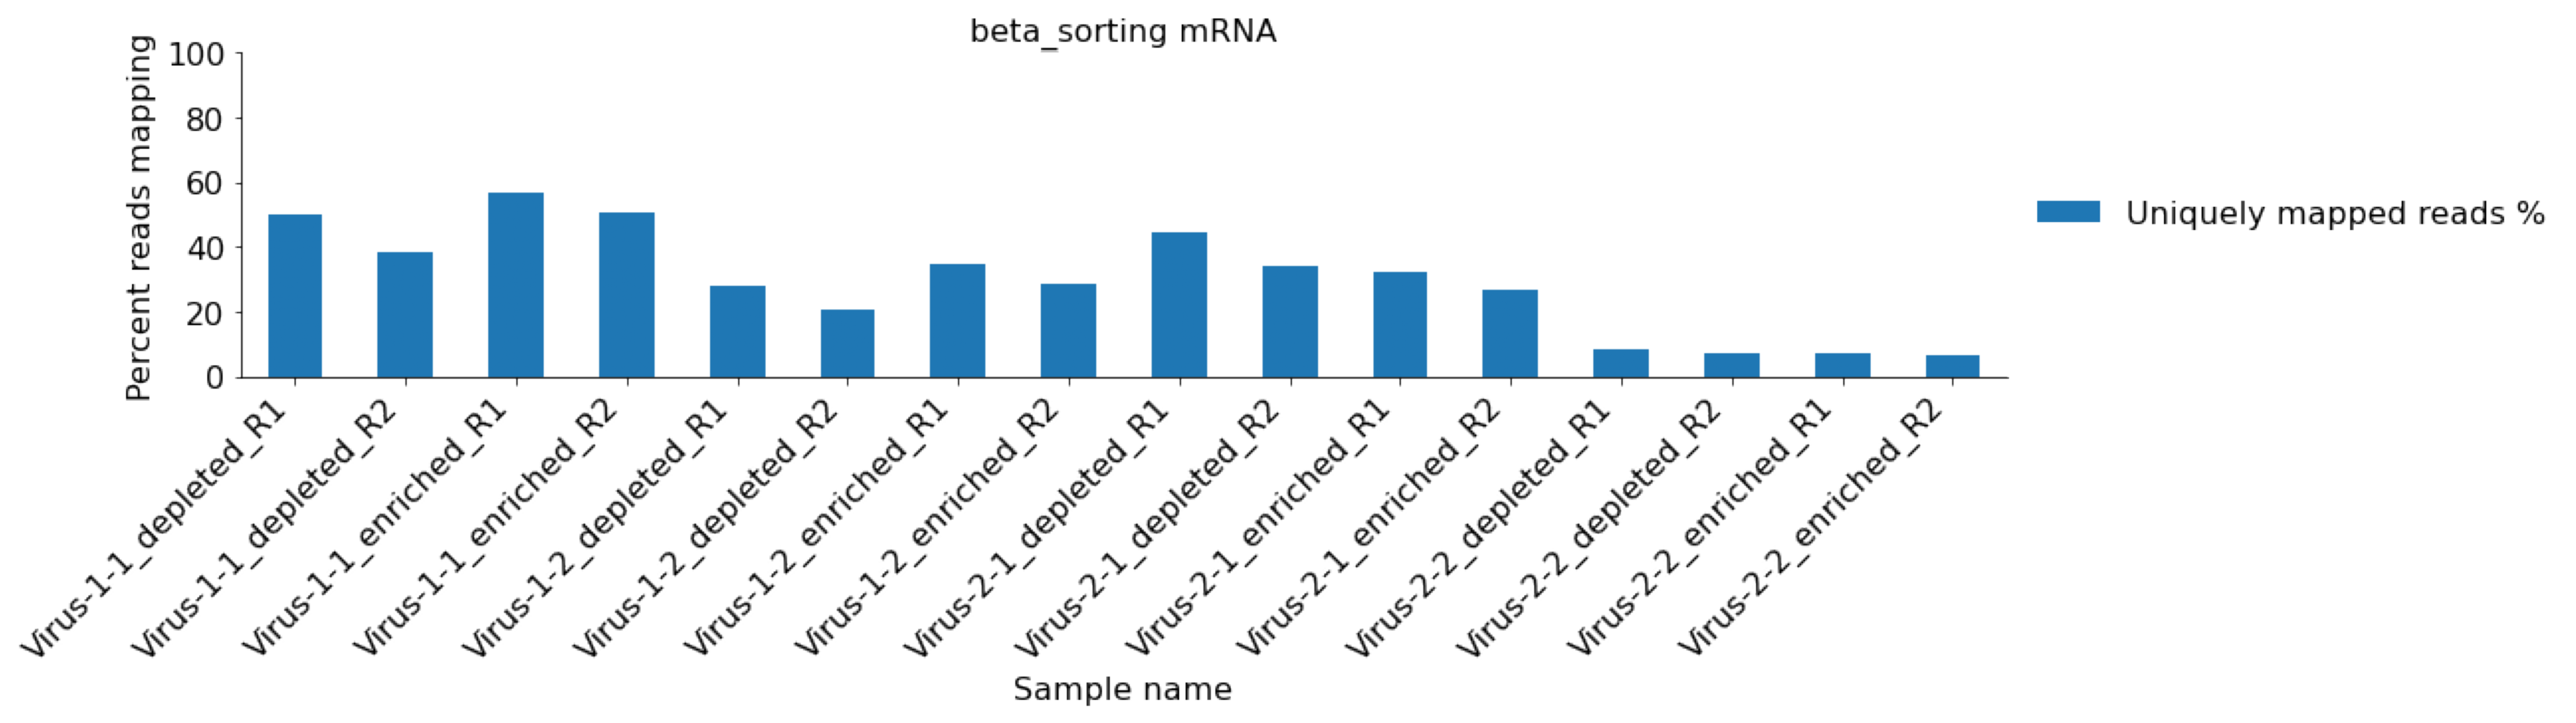

In [28]:
figsDisplay = []
reads = ['R1', 'R2']

for experiment in set(unique.experiment):
    currFrame = unique[(unique.experiment == experiment) & (unique.molecule_sequenced == 'vRNA')]
    data = []
    for index, row in currFrame.iterrows():
        for read in reads:
            sampleName = 'Virus-' + \
                   str(row.biological_replicate) + '-' + \
                   str(row.technical_replicate) + '_' + \
                   row.experimental_condition 
            filename = resultsDir + '/' + experiment + '_STARrealign/' + sampleName + '_vRNA_' + read + '_Log.final.out'
            sampleName = sampleName + '_' + read
            data += [fastQHandling.STARreport(filename,sampleName)]

    data = pd.concat(data)
    data.loc[:,['Uniquely mapped reads %','Sample name']].set_index('Sample name').plot.bar(stacked=True,figsize=(16,3), fontsize=16)
    sns.despine()
    plt.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.xticks(rotation=45,horizontalalignment="right")
    plt.ylabel('Percent reads mapping', fontsize=16)
    plt.ylim(0,100)
    plt.title(experiment + ' ' + molecule)
    plt.savefig(resultsDir + '/' + experiment + '_STARrealign/alignment.pdf', format='pdf', bbox_inches = "tight")
    #png for showing here
    plt.savefig(resultsDir + '/' + experiment + '_STARrealign/alignment.png', format='png', bbox_inches = "tight")
    plt.close()
    figsDisplay += [resultsDir + '/' + experiment + '_STARrealign/alignment.png']
width = 64 * len(figsDisplay)
g = plt.figure(1, (width, 32))
spec = g.add_gridspec(ncols= len(figsDisplay),nrows=1)
for column, fig in enumerate(figsDisplay):
    ax = g.add_subplot(spec[0,column])
    img=mpimg.imread(fig)
    ax.imshow(img)
    ax.axis('off')

Merge all 4 bamfiles (R1x2, R2x2, originally mapped and originally unmapped but now remapped). Sort by name, fix flags, and then make an additional position-sorted file. Saving both bamfiles costs us some space, but will make a lot of downstream efforts go much faster.

While clunky, I will use intermediate files. This "saves" on RAM usage at the cost of temporary high hard-drive usage. I feel RAM is a bit trickier, whereas if one is running this pipeline with a lack of hard drive space.....well the odds that they have a ton of RAM seems unlikely.

Samtools fixmate does not appear to fix the 0x2 flag here, so word of warning. Will rely on 0x1 flag to pull paired reads, and will go ahead and use extra code to "error-check" whether ends are consistent with the measurements being made.


In [29]:
for experiment in set(unique[unique.molecule_sequenced == 'vRNA'].experiment):
    if not os.path.isdir(resultsDir + '/' + experiment + '_finalAlign/'):
        os.mkdir(resultsDir + '/' + experiment + '_finalAlign/')
for index, row in unique[unique.molecule_sequenced == 'vRNA'].iterrows():
    experiment = row.experiment
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition + '_vRNA'
    outbase = resultsDir + '/' + experiment + '_finalAlign/' + sampleName
    firstAlignBase = resultsDir + '/' +  experiment + '_STARalign/' + sampleName
    secondAlignBase  = resultsDir + '/' +  experiment + '_STARrealign/' + sampleName
    b1_1 = firstAlignBase + '_R1_Aligned.out.bam'
    b1_2 = firstAlignBase + '_R2_Aligned.out.bam'
    b2_1 = secondAlignBase + '_R1_Aligned.out.bam'
    b2_2 = secondAlignBase + '_R2_Aligned.out.bam'
    tempBam = outbase + '_temp.bam'
    finBam = outbase + '.bam'
    possortBam = outbase + '_position.bam'
    extraCores = numProcessors - 1
    cap = !samtools merge -@ $extraCores $finBam $b1_1 $b1_2 $b2_1 $b2_2
    cap = !samtools sort -n -@ $extraCores -o $tempBam $finBam
    cap = !samtools fixmate -p -@ $extraCores $tempBam $finBam
    cap = !rm -f $tempBam
    cap = !samtools sort -@ $extraCores -o $possortBam $finBam
    !samtools index $possortBam

Raw counts of fragments mapping accross a given deletion junction.

Will only retain fragments wherein both reads are concordant- ie consistent with deletion even if it didn't exist (this will increase runtime considerably...but is unavoidable). Lastly, we will require at least 3 bases of mapping on either side of the junction to consider a deletion (in either read).


In [30]:
def rawFragMaps(arguments):
    DeletionAnalysis.rawCounts(junctionFile = arguments[0],sortedBamfile=arguments[1], 
                               outDirectory=arguments[2], requiredMapped=3)
popList = []
for experiment in set(unique[unique.molecule_sequenced == 'vRNA'].experiment):
    if not os.path.isdir(resultsDir + '/' + experiment + '_RawFragmentCounts/'):
        os.mkdir(resultsDir + '/' + experiment + '_RawFragmentCounts/')
for index, row in unique[unique.molecule_sequenced == 'vRNA'].iterrows():
    experiment = row.experiment
    outDirectory = resultsDir + '/' + experiment + '_RawFragmentCounts/'
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition + '_vRNA'
    junctionFile = resultsDir + '/' + experiment + '_junctionData/Virus-' + str(row.biological_replicate) + '/threshold_intron.tsv'
    bamfile = resultsDir + '/' + experiment + '_finalAlign/' + sampleName + '.bam'
    popList.append((junctionFile, bamfile, outDirectory))

while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(rawFragMaps, [popList.pop() for i in range(numProcessors) if len(popList) != 0] )


Total mapped fragments

In [32]:
outputDir = 'Results/beta_sorting_totalFragments/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)
def totalFrag(arguments):
    bamfile = arguments[0]
    numbers = []
    for segment in segments:
        command = f"samtools view -f 0x1 -F 0x900 {bamfile} {segment}"
        command += " | awk '{if($9 != 0) {print $0}}' | wc -l"
        process = subprocess.Popen(command, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        #using float as should always be an int, this is just a little check for me
        number = (float(stdout.decode('utf-8')))/float(2)
        numbers += [pd.DataFrame({'segment':[segment], "fragments":[number]})]
    pd.concat(numbers).to_csv(arguments[1], sep='\t')
    

popList = []
for index, row in unique[unique.molecule_sequenced == 'vRNA'].iterrows():
    experiment = row.experiment
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition + '_vRNA'
    bamfile = resultsDir + '/' + experiment + '_finalAlign/' + sampleName + '_position.bam'
    outfile = outputDir + sampleName + '_totalFragments.tsv'
    popList.append((bamfile, outfile))
    
while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(totalFrag, [popList.pop() for i in range(numProcessors) if len(popList) != 0] )





# Graphing of data

Did interferon enrichment work? Look at DESeq2 analysis

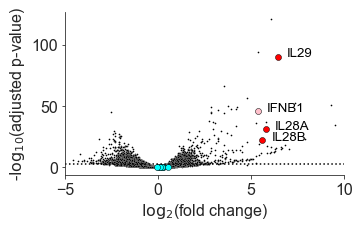

In [2]:
IFN_typeI = ['IFNB1']
IFN_typeIII = ['IL28A', 'IL28B','IL29']
IFN = IFN_typeI + IFN_typeIII
Flu = ['PB2','PB1','PA','HA','NP','NA_mRNA','M_mRNA', 'NS_mRNA']
DEseq2results = pd.read_csv('Results/DESeq.tsv', sep='\t')
DEseq2results['gene'] = DEseq2results['Unnamed: 0']
DEseq2results = DEseq2results.dropna(axis=0)
DEseq2results['-log(pValue)'] = -(np.log(DEseq2results.padj))
fig, ax = plt.subplots(figsize=[5,3])
ax = sns.scatterplot(data=DEseq2results, x="log2FoldChange", y='-log(pValue)', s=3, color='0', rasterized=True, ax=ax)

sns.scatterplot(data=DEseq2results[DEseq2results.gene.isin(Flu)], x="log2FoldChange", y='-log(pValue)', ax =ax, color='cyan',edgecolor="black", rasterized=True)
sns.scatterplot(data=DEseq2results[DEseq2results.gene.isin(IFN_typeI)], x="log2FoldChange", y='-log(pValue)', ax =ax, color='pink',edgecolor="black", rasterized=True,)
sns.scatterplot(data=DEseq2results[DEseq2results.gene.isin(IFN_typeIII)], x="log2FoldChange", y='-log(pValue)', ax =ax, color='red',edgecolor="black",rasterized=True)

sns.despine()
IFNplot = DEseq2results[DEseq2results.gene.isin(IFN)]
        
        
for line in range(0,IFNplot.shape[0]):
    ax.text(IFNplot["log2FoldChange"].iloc[line]+0.5, IFNplot['-log(pValue)'].iloc[line], 
             IFNplot['gene'].iloc[line], horizontalalignment='left', 
             size='small', color='black')
ax.axhline(y=-(np.log(0.05)), c="0", ls=":")
plt.xlim(-5,10)
a = plt.ylabel(r'-$\log_{10}$(adjusted p-value)')
a = plt.xlabel(r'$\log_2$(fold change)')
plt.savefig('Figures/betamRNAseq.pdf', format='pdf', bbox_inches = "tight", dpi=400)

Lets just start with the relative fraction, within each segment, of junction-spanning segments between our two conditions.

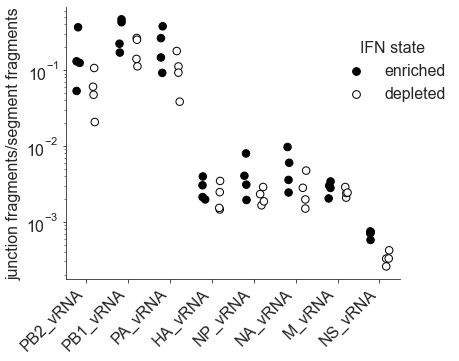

In [3]:

totalFrag = []
for file in glob.glob('Results/beta_sorting_totalFragments/*_totalFragments.tsv'):
    sampleName = file.split('/')[-1].split('_')[0]
    tempFrame = pd.read_csv(file, sep='\t')
    tempFrame['IFNstate'] = file.split('/')[-1].split('_')[1]
    tempFrame['bioRep'] = sampleName.split('-')[1]
    tempFrame['techRep'] = sampleName.split('-')[2]
    totalFrag += [tempFrame]
totalFrag = pd.concat(totalFrag)
junctionFrag = []
for file in glob.glob('Results/beta_sorting_RawFragmentCounts/*fragmentCountsRaw.tsv'):
    sampleName = file.split('/')[-1].split('_')[0]
    tempFrame = pd.read_csv(file, sep='\t')[['counts', 'segment']]
    tempFrame = tempFrame.groupby(['segment']).sum().reset_index()
    tempFrame['IFNstate'] = file.split('/')[-1].split('_')[1]
    tempFrame['bioRep'] = sampleName.split('-')[1]
    tempFrame['techRep'] = sampleName.split('-')[2]
    junctionFrag += [tempFrame]

junctionFrag = pd.concat(junctionFrag)
data = junctionFrag.merge(totalFrag, on=['segment', 'IFNstate','bioRep','techRep'])
data['fraction'] = data['counts']/data['fragments']


fig, ax = plt.subplots(1,1,figsize=[6,5])

sns.stripplot(x='segment', y='fraction', data=data,  edgecolor='black', order = segments,
            jitter=True, dodge=True, linewidth=1, s=7.5, hue="IFNstate", hue_order=['enriched', 'depleted'],palette=['0','1'], ax=ax, clip_on=False)


sns.despine()
handles, labels = ax.get_legend_handles_labels()
plt.yscale('log')
ax.get_legend().remove()
a =plt.xticks(np.arange(0,8,1),segments)
a = plt.xlabel('')

plt.ylabel('junction fragments/segment fragments')
a = plt.xticks(rotation=45, ha='right')
ax.legend(handles[0:2], labels[0:2], bbox_to_anchor=(0.8, 0.9), loc=2, borderaxespad=0.,frameon=False, title='IFN state')
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')
plt.savefig('Figures/rawjunctionbeta.pdf', format='pdf', bbox_inches = "tight")

Individual replicates enriched, running statistics at a stringent corrected q-value (benjamini) of 0.05

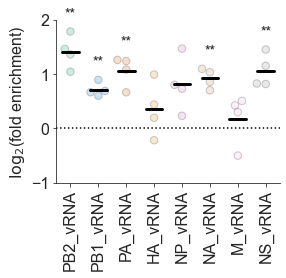

In [4]:
pivoted = data.pivot_table(index=['segment','bioRep','techRep'], columns='IFNstate', values='fraction').reset_index()
pivoted['enrichment'] = np.log2(pivoted.enriched/pivoted.depleted)
fig, ax = plt.subplots(1,1,figsize=[4,3])

sns.swarmplot(y='enrichment', x='segment', data=pivoted, order=segments, palette = fluColors, edgecolor='0',        
                dodge=True, linewidth=1, s=7.5, ax = ax, alpha=0.2, zorder=5)
sns.despine()
plt.ylim(-1,2)
a = plt.xticks(rotation=90, ha='center')
ax.axhline(y = 0, c="0", ls=":")
#handle statistics
pvals = []
for segment in segments:
    pvals += [stats.ttest_1samp(pivoted[pivoted.segment == segment].enrichment,0)[1]]
retain = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
for position, value in enumerate(retain):
    if value:
        # statistical annotation
        y = pivoted[pivoted.segment == segments[position]].enrichment.max() + 0.2
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
    y = pivoted[pivoted.segment == segments[position]].enrichment.mean()
    plt.plot([position-0.3, position+0.3], [y, y], lw=3, c='k', zorder=8)



a =plt.xticks(np.arange(0,8,1),segments)
a = plt.xlabel('')
a = plt.ylabel(r'$\log_2$(fold enrichment)')
plt.savefig('Figures/betaenrich.pdf', format='pdf', bbox_inches = "tight")

Replicate correlation

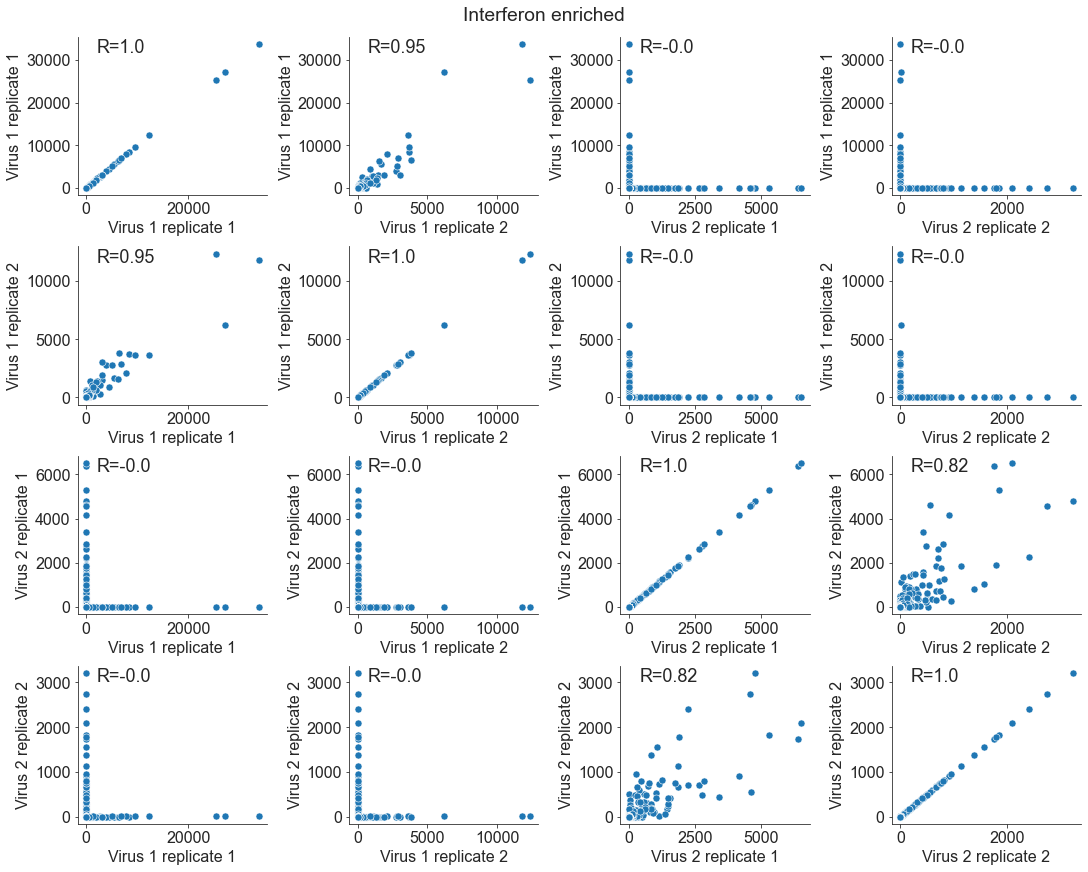

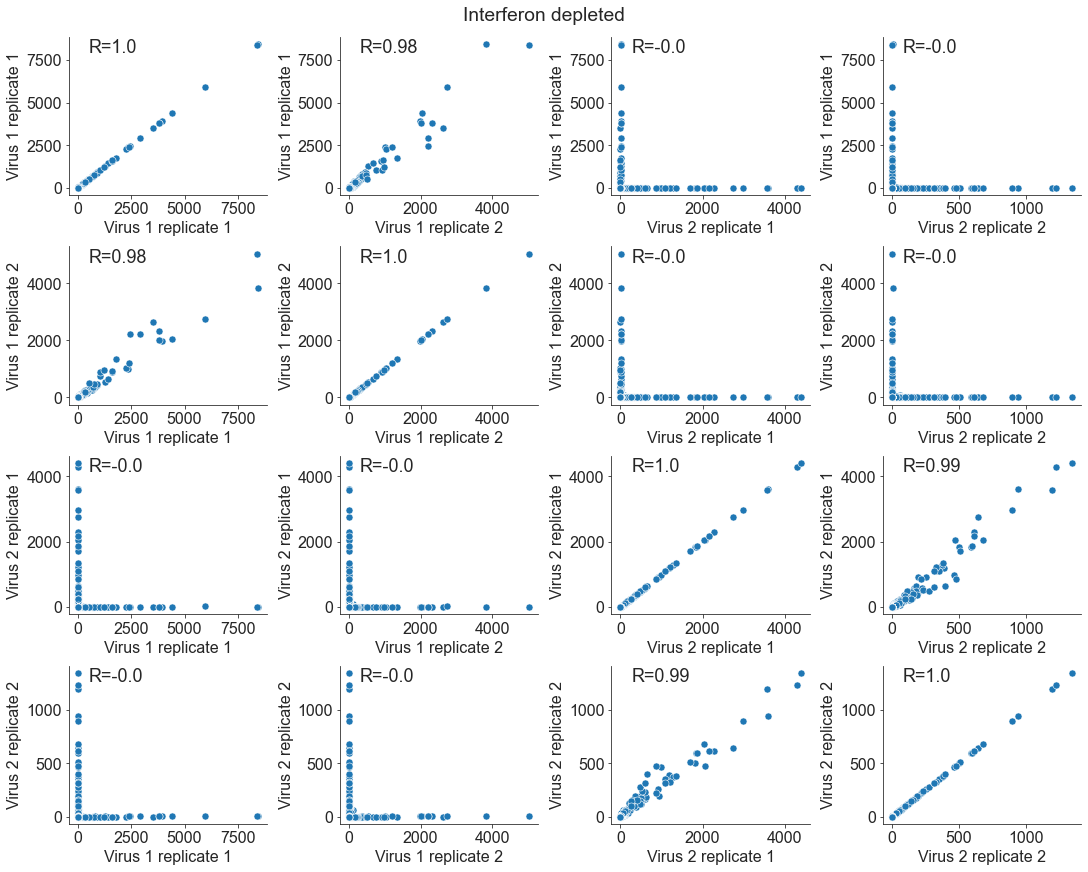

In [9]:
junctionFrag = []

for file in glob.glob('Results/beta_sorting_RawFragmentCounts/*fragmentCountsRaw.tsv'):
    sampleName = file.split('/')[-1].split('_')[0]
    tempFrame = pd.read_csv(file, sep='\t')
    tempFrame['IFNstate'] = file.split('/')[-1].split('_')[1]
    tempFrame['bioRep'] = sampleName.split('-')[1]
    tempFrame['techRep'] = sampleName.split('-')[2]
    junctionFrag += [tempFrame]

junctionFrag = pd.concat(junctionFrag)


junctionFrag =junctionFrag.pivot_table(index=['fivePrime','threePrime','segment', 'IFNstate'], columns=['bioRep','techRep'], values='counts').reset_index().fillna(0)

y = 1
for condition in ['enriched', 'depleted']:
    
    columns = 4
    rows = 4
    height = 3
    width = 3
    
    g= plt.figure(y,(width*(columns+1),rows*height), constrained_layout=True)
    spec = g.add_gridspec(rows,columns)
    y+=1

    currRow = 0
    currCol = 0
    for bioRep in ['1','2']:
        for techRep in ['1','2']:
            for bioRep2 in ['1','2']:
                for techRep2 in ['1','2']:
                    tempFrame = pd.DataFrame()
                    yAxis = 'Virus ' + bioRep + ' replicate ' + techRep
                    xAxis = 'Virus ' + bioRep2 + ' replicate ' + techRep2
                    ax = g.add_subplot(spec[currRow, currCol])
                    currCol = (currCol + 1)%columns
                    if currCol == 0:
                        currRow += 1
                    tempFrame[yAxis] = junctionFrag[junctionFrag.IFNstate == condition][bioRep][techRep]
                    tempFrame[xAxis] = junctionFrag[junctionFrag.IFNstate == condition][bioRep2][techRep2]
                    sns.scatterplot(data = tempFrame, x=xAxis, y=yAxis,  legend=False, ax=ax, rasterized=True, s= 50)
                    sns.despine()
                    Rval = round(tempFrame.corr()[xAxis].iloc[0],2)
                    ax.text(0.1, 0.9, 'R=' + str(Rval), transform=ax.transAxes, fontsize = 18)
    plt.suptitle('Interferon ' + condition)
    plt.savefig('Figures/betaCorrelation' + condition +'.pdf', format='pdf', bbox_inches = "tight", dpi=100)
            
    

Lastly lets graph depth to show enrichment. Requires samtools. First lets just write to file to make things a bit easier

In [43]:
for file in glob.glob('Results/beta_sorting_finalAlign/*_position.bam'):
    output = file[:-13] + '_depth.tsv'
    !samtools depth $file > $output


Now plot. Fractional depth. Area under the curve adds up to 1.

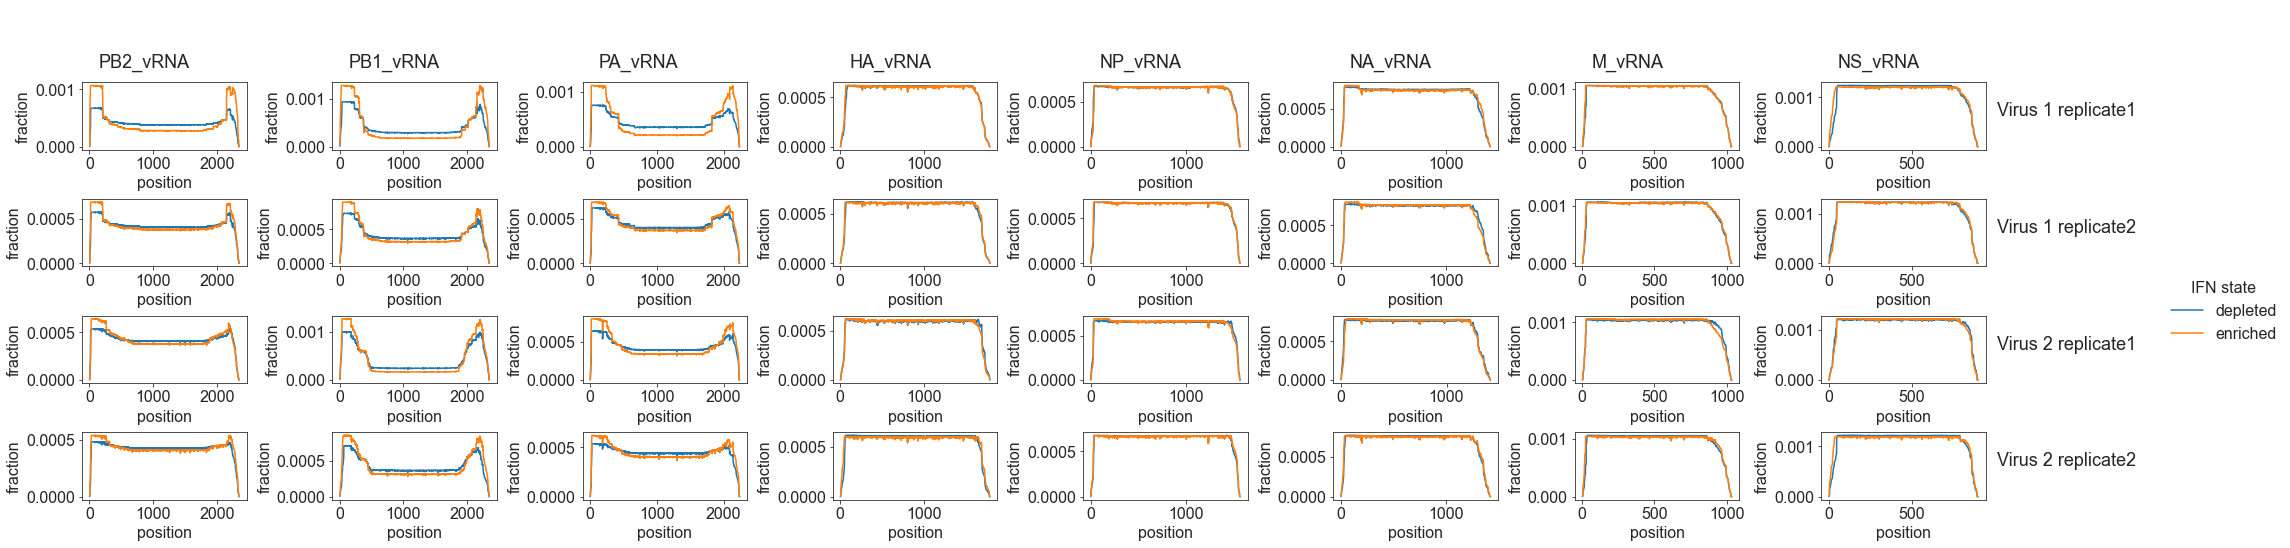

In [14]:
data = []

for file in glob.glob('Results/beta_sorting_finalAlign/*_depth.tsv'):
    tempFrame = pd.read_csv(file, sep='\t', names=['segment','position','depth'])
    interferon = file.split('_')[-3]
    techRep = file.split('-')[-1].split('_')[0]
    bioRep = file.split('-')[-2]
    sums = tempFrame.groupby(['segment'])['depth'].sum().reset_index().rename(columns={'depth':'sum'})
    tempFrame = tempFrame.merge(sums, on=['segment'])
    tempFrame['fraction'] = tempFrame['depth']/tempFrame['sum']
    tempFrame['biological_replicate'] = bioRep
    tempFrame['technical_replicate'] = techRep
    tempFrame['IFNstate'] = interferon
    data += [tempFrame]
data = pd.concat(data)
columns = 9
rows = 5
height = 1.5
width = 3
    
g= plt.figure(1,(width*(columns+1),rows*height), constrained_layout=True)
spec = g.add_gridspec(rows,columns)

currRow = 0
currCol = 0
for segment in segments:
    ax = g.add_subplot(spec[currRow, currCol])
    currCol +=1
    ax.set_axis_off()
    ax.text(0.1, 0.1, segment, transform=ax.transAxes, fontsize = 18)
currRow += 1
currCol = 0

for bioRep in ['1','2']:
    for techRep in ['1','2']:
        for segment in segments:
            tempFrame = data.loc[(data.segment == segment) & (data.biological_replicate == bioRep) & (data.technical_replicate == techRep),]
            title = 'Virus ' + bioRep + ' replicate' + techRep
            ax = g.add_subplot(spec[currRow, currCol])
            currCol = (currCol + 1)%(columns - 1)
            sns.lineplot(data=tempFrame, x='position', y='fraction', hue='IFNstate', ci=None )
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
            if currCol == 0:
                ax = g.add_subplot(spec[currRow, columns-1])
                ax.set_axis_off()
                ax.text(0, 0.5, title, transform=ax.transAxes, fontsize = 18)
                currRow += 1
g.legend(handles, labels, bbox_to_anchor=(1.0, 0.5), loc=2, borderaxespad=0.,frameon=False, title='IFN state')
plt.savefig('Figures/betaAllSegmentsDepth.pdf', format='pdf', bbox_inches = "tight", dpi=400)
